In [2]:
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm as tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import utils
import torch.nn as nn
import numpy as np
import os, imageio
import pickle
import torch
import cv2

### Model

In [3]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50) # input has 4 dimensions.
        self.fc1_drop = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50,1)

    def forward(self, x):
        # x = x.view(-1,4) # input has 4 dimensions.
        x = self.relu1(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.relu2(self.fc2(x))
        x = self.fc2_drop(x)
        return self.fc3(x)

In [6]:
import pandas as pd
import pickle 

In [7]:
with open("../data/labels", 'rb') as fp:
    targets = pickle.load(fp)

with open('../data/weights_dictionary.pkl', 'rb') as fp:
    weights = pickle.load(fp)

In [28]:
weights_pd = pd.DataFrame.from_dict(weights)
weights_pd['digit'] = pd.Series(targets).map(lambda x: 'Digit {}'.format(x))

In [22]:
weights_array = np.array(tuple(weights.values()))

In [24]:
import umap

c:\MLAI\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\MLAI\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\MLAI\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' dec

In [25]:
reducer = umap.UMAP(random_state=42)

In [37]:
weights_array.shape

(10000, 9051)

In [44]:
np.delete(weights_array,np.s_[3:-1],1)

array([[ 2.55564805e-02,  6.64647676e-02,  6.97660672e-02,
        -1.28396975e-03],
       [-1.20815012e-01, -2.40041289e-02, -2.48294747e-01,
         1.66893285e-03],
       [-9.64852408e-02,  3.42778061e-02, -8.35764645e-02,
        -2.61481815e-04],
       ...,
       [-4.61592720e-01,  1.53642589e-01,  1.97716417e-01,
         7.79636866e-04],
       [-2.52807177e-02,  8.63288940e-02,  1.58096803e-02,
         1.03113862e-03],
       [-5.78905528e-03, -1.77727570e-01, -8.92795762e-02,
        -2.79587485e-03]])

In [45]:
embedding = reducer.fit_transform(np.delete(weights_array,np.s_[5:-1],1))

In [46]:
print(np.shape(embedding))

(10000, 2)


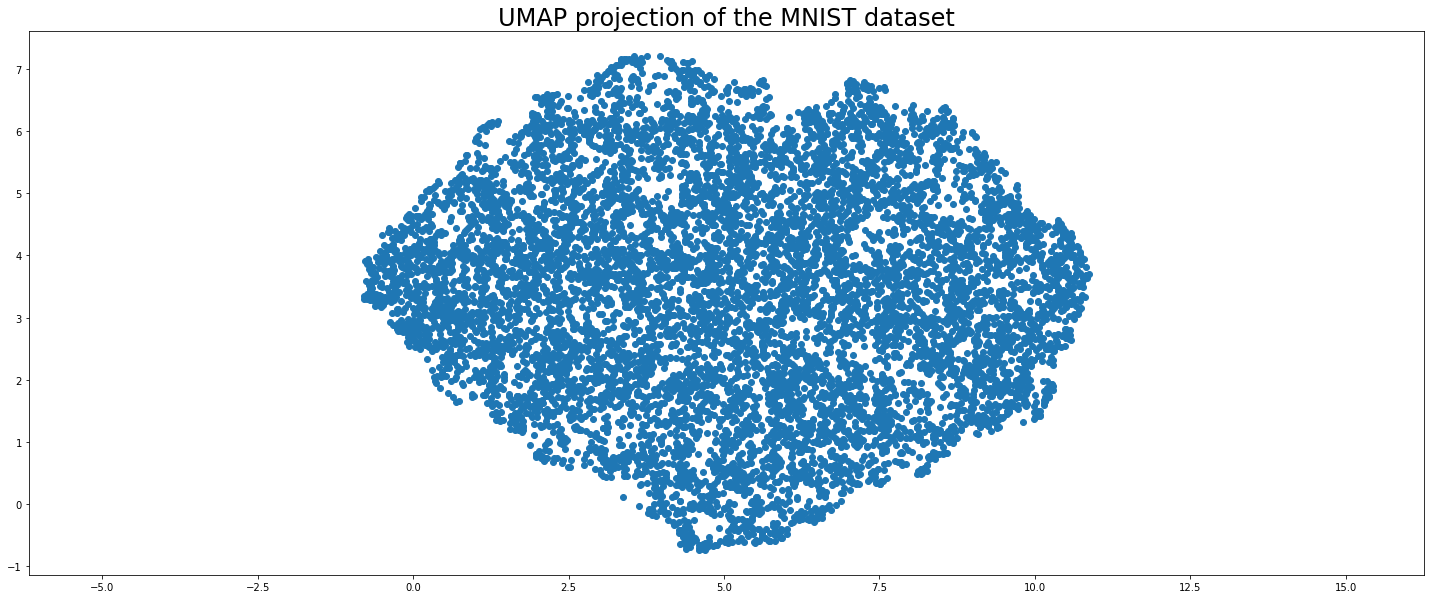

In [47]:
import seaborn as sns

plt.figure(figsize=[25,10])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the MNIST dataset', fontsize=24)
plt.show()

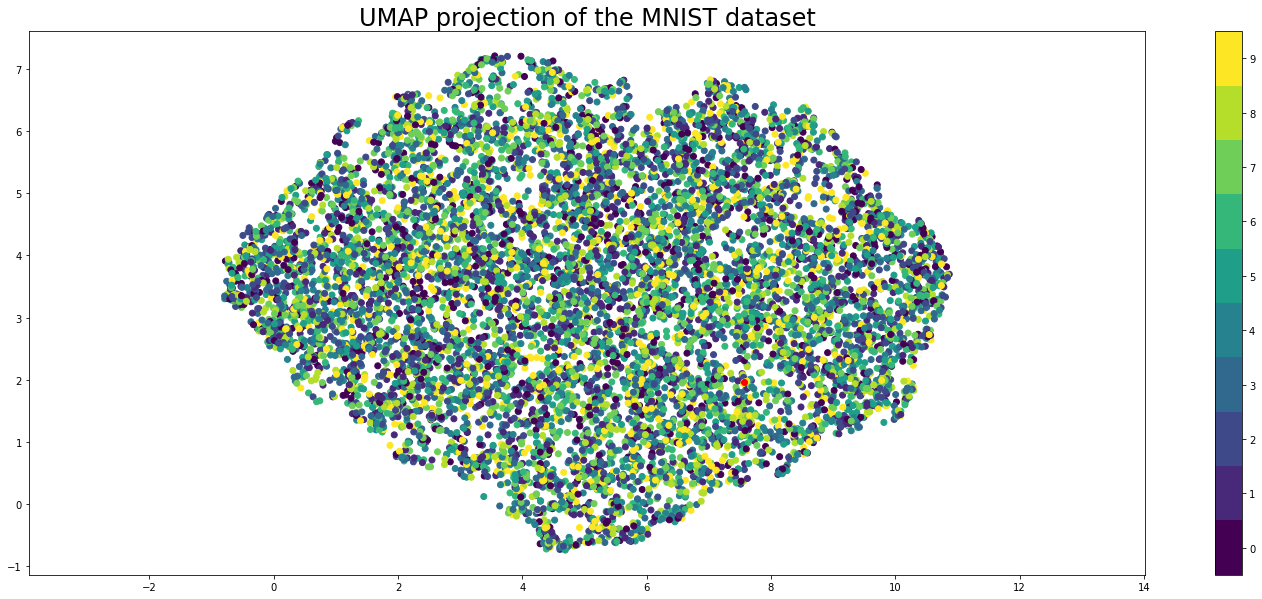

In [50]:
import seaborn as sns

plt.figure(figsize=[25,10])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=targets
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the MNIST dataset', fontsize=24)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.scatter(embedding[9999,0], embedding[9999,1],color='r')
plt.show()